Import Libraries

In [53]:
import os
import pandas as pd
import numpy as np
import json


In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
categorized_questions_file = '../categorized_questions.jsonl'

# read categorized questions
categorized_questions = []
with open(categorized_questions_file, 'r') as f:
    for line in f:
        categorized_questions.append(json.loads(line))

# List of all questions
categorized_questions_list = [list(q.values())[0] for q in categorized_questions]

# create a dictionary to map questions to their categories
question_to_category = {q['Question']: q['Category'] for q in categorized_questions}

In [56]:
# all unique categories in question_to_category
unique_categories = sorted(set(question_to_category.values()))
print(f"Lenght of unique categories: {len(unique_categories)}")
print(unique_categories)

Lenght of unique categories: 15
['A. Social values and attitudes', 'B. Religion and spirituality', 'C. Science and technology', 'D. Politics and policy', 'E. Demographics', 'G. International affairs', 'I. Gender and LGBTQ', 'J. News habits and media', 'K. Immigration and migration', 'L. Family and relationships', 'M. Race and ethnicity', 'N. Economy and work', 'O. Regions and countries', 'P. Methodological research', 'Q. Security']


#### Load of the CSV Data
- CSV Data: CSV Files for Dollar Street dataset
- No. of countries are: __

In [57]:
import pandas as pd
from scipy.spatial import distance
import ast

# List all files in the directory
directory = "/Users/srishtiy/dev/cultural_values/notebooks/outputs"

# True => Country was in the prompt
# False => Country was not in the prompt, only image was used

# country_image_file_list = ['ds_wvs_metadata_llava-v1.5-13b_True_results.csv', 'ds_wvs_metadata_llava-v1.5-13b_False_results.csv',
#                             'ds_wvs_metadata_llava-v1.6-34b_True_results.csv', 'ds_wvs_metadata_llava-v1.6-34b_False_results.csv']
# country_image_file_list = ['ds_wvs_metadata_llava-v1.5-13b_True_results.csv', 'ds_wvs_metadata_llava-v1.6-vicuna-13b-hf_False_results.csv',
#                             'ds_wvs_metadata_llava-v1.6-34b_True_results.csv', 'ds_wvs_metadata_llava-v1.6-34b_False_results.csv']
country_image_file_list = ['ds_wvs_metadata_llava-v1.6-vicuna-13b_True_results.csv', 'ds_wvs_metadata_llava-v1.6-vicuna-13b_False_results.csv',
                            'ds_wvs_metadata_llava-v1.6-34b_True_results.csv', 'ds_wvs_metadata_llava-v1.6-34b_False_results.csv',
                            'ds_wvs_metadata_llava-next-72b-hf_True_results.csv', 'ds_wvs_metadata_llava-next-72b-hf_False_results.csv']

# check if files are present in the directory
for file in country_image_file_list:
    if file not in os.listdir(directory):
        print(f"{file} not found in the directory")
    else:
        print(f"{file} found in the directory")



ds_wvs_metadata_llava-v1.6-vicuna-13b_True_results.csv found in the directory
ds_wvs_metadata_llava-v1.6-vicuna-13b_False_results.csv found in the directory
ds_wvs_metadata_llava-v1.6-34b_True_results.csv found in the directory
ds_wvs_metadata_llava-v1.6-34b_False_results.csv found in the directory
ds_wvs_metadata_llava-next-72b-hf_True_results.csv found in the directory
ds_wvs_metadata_llava-next-72b-hf_False_results.csv found in the directory


### Create a combine dataframe for both country and image level data
-  Image and text dataframe will be concatenated
- 'Image' column will be True for Image level data and False for Country level data
- 'jsd' and 'similarity' columns have Jensen Shannon Divergence and Similarity (1-JSD) values for each question
- 'coutry_mean_similarity' and 'country_mean_jsd' columns have mean similarity and JSD values for each country

In [58]:
results = []

# loop over data_image and data_country
for idx, each_file in enumerate(country_image_file_list):
    
    # 'True' => Country was in the prompt, 'False' => Country was not in the prompt, only image was used
    has_image = 'True' if 'False' in each_file else 'False' if 'True' in each_file else print("Missing: Neither 'True' nor 'False' is present in the file name")
    modelsize = '13b' if '13b' in each_file else '34b' if '34b' in each_file else '72b' if '72b' in each_file else print("Missing: Model size is not present in the file name")
    
    print(f"Processing file: {each_file}, has_image: {has_image}, modelsize: {modelsize}")
    
    each_data = pd.read_csv(os.path.join(directory, each_file))
    data = each_data

    # Example gt and pred (list of lists)
    gt = [ast.literal_eval(x) for x in data['selection_answers'].tolist()] # there are prob distrbutions of human answers
    pred = [ast.literal_eval(x) for x in data['prob_percent_values'].tolist()] # there are prob distrbutions of model answers

    # Original DataFrame, retaining all columns from `data`
    df = data.copy()

    # Keep track of matching indices
    matching_indices = [i for i, (g, p) in enumerate(zip(gt, pred)) if len(g) == len(p)]

    # Filter rows where len(g) == len(p)
    filtered_gt_pred = [(g, p) for g, p in zip(gt, pred) if len(g) == len(p)]

    # If there are any matching rows
    if filtered_gt_pred:
        gt_filtered, pred_filtered = zip(*filtered_gt_pred)

        # Calculate JSD
        jsd = [distance.jensenshannon(g, p) for g, p in zip(gt_filtered, pred_filtered)]
        similarity = [1 - value for value in jsd]

        # Add JSD and similarity values back to the DataFrame
        df.loc[matching_indices, 'jsd'] = jsd
        df.loc[matching_indices, 'similarity'] = similarity
    else:
        df['jsd'] = None  # or handle the case accordingly
        df['similarity'] = None

    # Set JSD and similarity to NaN or a placeholder for rows that were filtered out
    df['jsd'] = pd.to_numeric(df['jsd'], errors='coerce')
    df['similarity'] = pd.to_numeric(df['similarity'], errors='coerce')
    
    df['Image'] = 'False' if has_image == 'False' else 'True' if has_image == 'True' else print("Something missing! Image is not True or False")
    df['model_size'] = modelsize

    #
    # Calculate mean of jsd and similarity per country per 'Image' column and add new col 'mean_jsd' and 'mean_similarity'
    df['country_mean_jsd'] = df.groupby(['country', 'Image'])['jsd'].transform('mean')
    df['coutry_mean_similarity'] = df.groupby(['country', 'Image'])['similarity'].transform('mean')

    # Append results to list
    results.append(df)

# Combine all results into a single DataFrame
final_results = pd.concat(results)
print(f"Pre filtered shape: {final_results.shape}")

# drop any rows with NaN values
final_results = final_results.dropna()
print(f"Post filtered shape: {final_results.shape}")

Processing file: ds_wvs_metadata_llava-v1.6-vicuna-13b_True_results.csv, has_image: False, modelsize: 13b
Processing file: ds_wvs_metadata_llava-v1.6-vicuna-13b_False_results.csv, has_image: True, modelsize: 13b
Processing file: ds_wvs_metadata_llava-v1.6-34b_True_results.csv, has_image: False, modelsize: 34b
Processing file: ds_wvs_metadata_llava-v1.6-34b_False_results.csv, has_image: True, modelsize: 34b
Processing file: ds_wvs_metadata_llava-next-72b-hf_True_results.csv, has_image: False, modelsize: 72b
Processing file: ds_wvs_metadata_llava-next-72b-hf_False_results.csv, has_image: True, modelsize: 72b
Pre filtered shape: (91560, 24)
Post filtered shape: (91092, 24)


In [ ]:
# show all rows in final_result where sum_prob_percent_sorted < 99
mnp = final_results[final_results['sum_prob_percent_sorted'] < 99][['image_path', 'prompt', 'sum_prob_percent_sorted', 'Image', 'model_size','jsd', 'similarity']]
print(mnp[['Image', 'model_size']].value_counts())

pd.set_option('display.max_colwidth', 300)
mnp.groupby(['Image', 'model_size','image_path']).count()


#### Filter rows where sum_prob_percent_sorted <99

In [61]:
print(f"Size of the total data: {final_results.shape}")
# Filter rows where sum_prob_percent_sorted <99
filtered_final_result = final_results[final_results['sum_prob_percent_sorted'] > 99]
print(f"Size of the filtered data: {filtered_final_result.shape}")

Size of the total data: (91092, 24)
Size of the filtered data: (91045, 24)


### Add 'question_topic' to both dataframes
- 'question_topic' is the column which has each question mapped to a broad topic
- Broad topics are: {'B. Religion and spirituality', 'E. Demographics', 'A. Social values and attitudes', 'D. Politics and policy', 'O. Regions and countries', 'J. News habits and media', 'G. International affairs', 'M. Race and ethnicity', 'N. Economy and work', 'P. Methodological research', 'C. Science and technology', 'K. Immigration and migration', 'L. Family and relationships', 'Q. Security', 'I. Gender and LGBTQ'}

In [62]:
filtered_final_result['question_topic'] = filtered_final_result['question_text'].map(question_to_category)
filtered_final_result.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'jsd', 'similarity',
       'Image', 'model_size', 'country_mean_jsd', 'coutry_mean_similarity',
       'question_topic'],
      dtype='object')

In [63]:
# count rows where nan values are present
filtered_final_result.isna().sum()

img_id                     0
image_path                 0
country                    0
image_code                 0
income                     0
question_text              0
country_prompt             0
generic_prompt             0
option_labels              0
full_options               0
prompt                     0
options                    0
top10_token_prob           0
prob_percent_sorted        0
sum_prob_percent_sorted    0
prob_percent_keys          0
prob_percent_values        0
selection_answers          0
jsd                        0
similarity                 0
Image                      0
model_size                 0
country_mean_jsd           0
coutry_mean_similarity     0
question_topic             0
dtype: int64

In [64]:
filtered_final_result['country'].unique()

array(['Bangladesh', 'Brazil', 'China', 'France', 'Iran', 'Italy',
       'Kenya', 'Mexico', 'Nigeria', 'Pakistan', 'South Korea', 'Spain',
       'United States', 'Vietnam'], dtype=object)

### For each question topic/model, calculate the mean similarity, JSD values, MD Sim for each country
- column names will be 'question_topic_mean_jsd' and 'question_topic_mean_similarity'
- For marginal distribution similarity, column name will be 'md_topic_pred', 'md_topic_gt', 'md_sim_topic', 'md_sim_overall'

In [65]:
ds_rich_countries = ["United States", "China", "Brazil"]
ds_poor_countries = ["Pakistan", "Nigeria", "Bangladesh"]

country_list = ds_rich_countries + ds_poor_countries

### Compute Marginal Distribution

Func for marginal distribution calculation

In [66]:
def average_distributions(distributions):
    # Ensure all distributions are lists (not strings)
    distributions = [ast.literal_eval(dist) if isinstance(dist, str) else dist for dist in distributions]
    
    # Ensure all distributions are valid lists of numbers
    valid_distributions = [np.array(dist, dtype=float) for dist in distributions if isinstance(dist, list)]

    # Calculate the average distribution
    average_dist =  np.mean(np.array(valid_distributions), axis=0).tolist()
    
    return average_dist

# General function to calculate marginal distribution and merge it back into the DataFrame
def calculate_and_merge_marginal_distribution(df, groupby_columns, target_column, new_column_name):
    """
    Generalized function to calculate marginal distribution, reset index, and merge back to the original DataFrame.
    """
    marginal_df = (
        df.groupby(groupby_columns)[target_column]
        .apply(average_distributions)
        .reset_index(name=new_column_name)
    )
    return df.merge(marginal_df, on=groupby_columns, how='left')

Func to compute jsd and 1-jsd for the marginalized distributions

In [67]:
from scipy.spatial.distance import jensenshannon

# Function to calculate Jensen-Shannon Divergence (JSD)
def calculate_jsd(p, q):
    if len(p) == 0 or len(q) == 0:  # Check for empty distributions
        return None  # or return a specific value indicating no valid distributions
    return jensenshannon(p, q)

Code to compute jsd and similarity (1-jsd) for 
- each question topic
- marginal distribution distribution

In [68]:
# for each question_topic, calculate mean of jsd and similarity per country and save as different df 
# save all dfs in a dictionary

# Calculate mean of 'jsd' per 'question_topic', Image'
filtered_final_result['question_topic_mean_jsd'] = filtered_final_result.groupby(['question_topic', 'Image', 'model_size'])['jsd'].transform('mean')
# Calculate mean of 'similarity' per 'question_topic','Image'
filtered_final_result['question_topic_mean_similarity'] = filtered_final_result.groupby(['question_topic', 'Image', 'model_size'])['similarity'].transform('mean')
# Calculate mean of 'question_topic_mean_similarity' per country
filtered_final_result['question_topic_country_mean_similarity'] = filtered_final_result.groupby(['question_topic', 'country', 'Image', 'model_size'])['similarity'].transform('mean')

filtered_final_result = calculate_and_merge_marginal_distribution(
    filtered_final_result, ['question_topic', 'question_text', 'Image', 'model_size'], 'prob_percent_values', 'md_topic_pred'
)

filtered_final_result = calculate_and_merge_marginal_distribution(
    filtered_final_result, ['question_topic', 'question_text', 'Image', 'model_size'], 'selection_answers', 'md_topic_gt'
)

# Step 3 and 4: Calculate marginalized model prediction and ground truth across all images per question only
filtered_final_result = calculate_and_merge_marginal_distribution(
    filtered_final_result, ['question_text', 'Image', 'model_size'], 'prob_percent_values', 'md_all_pred'
)

filtered_final_result = calculate_and_merge_marginal_distribution(
    filtered_final_result, ['question_text', 'Image', 'model_size'], 'selection_answers', 'md_all_gt'
)

# Calculate JSD for each question topic
filtered_final_result['md_jsd_topic'] = filtered_final_result.apply(
    lambda row: calculate_jsd(row['md_topic_pred'], row['md_topic_gt']), axis=1
)
filtered_final_result['md_sim_topic'] = 1 - filtered_final_result['md_jsd_topic']

# Calculate JSD for overall predictions and ground truth
filtered_final_result['md_jsd_overall'] = filtered_final_result.apply(
    lambda row: calculate_jsd(row['md_all_pred'], row['md_all_gt']), axis=1
)
filtered_final_result['md_sim_overall'] = 1 - filtered_final_result['md_jsd_overall']

# print column names
filtered_final_result.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'jsd', 'similarity',
       'Image', 'model_size', 'country_mean_jsd', 'coutry_mean_similarity',
       'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

### Save final df and (question)topic level data

In [69]:
import shutil
from tqdm import tqdm

question_topic_ouput_dir = 'topic_csv'

# delete directory if already exist. Include subdirectories
if os.path.exists(question_topic_ouput_dir):
    shutil.rmtree(question_topic_ouput_dir)
    print(f"Existed! Deleted {question_topic_ouput_dir} directory")

# create directory
os.makedirs(question_topic_ouput_dir)
print(f"Question Topic Level Data will be saved at: {question_topic_ouput_dir}")  

Existed! Deleted topic_csv directory
Question Topic Level Data will be saved at: topic_csv


In [70]:

filtered_final_result.to_csv(f"{question_topic_ouput_dir}/all_results.csv", index=False)
print(f"Saved data: {question_topic_ouput_dir}/all_results.csv")

# Create separate DataFrames per question topic and save them
df_category_similarity = {}
question_topics = sorted(filtered_final_result['question_topic'].unique())

for topic in tqdm(question_topics):
    df_category = filtered_final_result[filtered_final_result['question_topic'] == topic]
    df_category_similarity[topic] = df_category
    df_category.to_csv(f"{question_topic_ouput_dir}/{topic}.csv", index=False)
    print(f"Saved data: {question_topic_ouput_dir}/{topic}.csv")

print(f"Question Topic Level Data saved at: {question_topic_ouput_dir}")


Saved data: topic_csv/all_results.csv


  0%|          | 0/15 [00:00<?, ?it/s]

Saved data: topic_csv/A. Social values and attitudes.csv


 13%|█▎        | 2/15 [00:00<00:03,  3.40it/s]

Saved data: topic_csv/B. Religion and spirituality.csv


 20%|██        | 3/15 [00:01<00:04,  2.56it/s]

Saved data: topic_csv/C. Science and technology.csv


 33%|███▎      | 5/15 [00:03<00:07,  1.29it/s]

Saved data: topic_csv/D. Politics and policy.csv
Saved data: topic_csv/E. Demographics.csv


 40%|████      | 6/15 [00:03<00:05,  1.67it/s]

Saved data: topic_csv/G. International affairs.csv


 47%|████▋     | 7/15 [00:04<00:03,  2.00it/s]

Saved data: topic_csv/I. Gender and LGBTQ.csv


 53%|█████▎    | 8/15 [00:04<00:02,  2.38it/s]

Saved data: topic_csv/J. News habits and media.csv


 60%|██████    | 9/15 [00:04<00:02,  2.43it/s]

Saved data: topic_csv/K. Immigration and migration.csv


 73%|███████▎  | 11/15 [00:06<00:02,  1.94it/s]

Saved data: topic_csv/L. Family and relationships.csv
Saved data: topic_csv/M. Race and ethnicity.csv


 80%|████████  | 12/15 [00:07<00:02,  1.42it/s]

Saved data: topic_csv/N. Economy and work.csv


 87%|████████▋ | 13/15 [00:08<00:01,  1.27it/s]

Saved data: topic_csv/O. Regions and countries.csv


 93%|█████████▎| 14/15 [00:13<00:02,  2.21s/it]

Saved data: topic_csv/P. Methodological research.csv


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]

Saved data: topic_csv/Q. Security.csv
Question Topic Level Data saved at: topic_csv


In [71]:
df_category_similarity.keys()

dict_keys(['A. Social values and attitudes', 'B. Religion and spirituality', 'C. Science and technology', 'D. Politics and policy', 'E. Demographics', 'G. International affairs', 'I. Gender and LGBTQ', 'J. News habits and media', 'K. Immigration and migration', 'L. Family and relationships', 'M. Race and ethnicity', 'N. Economy and work', 'O. Regions and countries', 'P. Methodological research', 'Q. Security'])

#### Swarm Plot for Income Level Analysis

In [72]:
import torch
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Create mapping from country to income group
country_income_group = {}
for country in ds_rich_countries:
    country_income_group[country] = 'High Income'
for country in ds_poor_countries:
    country_income_group[country] = 'Low Income'

def extract_income_value(tensor_value):
    if isinstance(tensor_value, str):
        # Use regex to extract the number inside 'tensor(...)'
        match = re.search(r'tensor\(([\d\.\-e]+)', tensor_value)
        if match:
            return float(match.group(1))
        else:
            return np.nan  # or raise an error if appropriate
    elif isinstance(tensor_value, torch.Tensor):
        return tensor_value.item()
    else:
        return float(tensor_value)

In [75]:
# import os
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # ---------------------------
# # Step 1: Sort Countries by Mean Income
# # ---------------------------

# # # Apply the function to the 'income' column
# filtered_final_result['income_value'] = filtered_final_result['income'].apply(extract_income_value)

# # # Get all images per country
# # country_income_df = filtered_final_result[['country', 'img_id', 'income_value']].drop_duplicates()
# country_income_df = filtered_final_result[filtered_final_result['country'].isin(country_list)][['country', 'income_value']].drop_duplicates()

# # Calculate mean income per country and sort them in descending order
# country_mean_income = country_income_df.groupby('country')['income_value'].mean().sort_values(ascending=False)

# # Extract the sorted list of countries
# # sorted_countries = country_mean_income.index.tolist()

# # Define high-income and low-income countries
# high_income_countries = country_list[:3]  # Top 3
# low_income_countries = country_list[-3:]  # Bottom 3

# # Update 'country' column as a categorical type with the sorted order
# country_income_df['country'] = pd.Categorical(
#     country_income_df['country'],
#     categories=country_list,
#     ordered=True
# )

# # ---------------------------
# # Step 2: Plot Combined Income Distribution and Country-Level Data
# # ---------------------------

# plt.figure(figsize=(6, 3))  # Increased width for better readability

# # Create boxplot
# sns.boxplot(
#     x='country',
#     y='income_value',
#     data=country_income_df,
#     palette='Pastel1'
# )

# # Overlay swarmplot
# sns.swarmplot(
#     x='country',
#     y='income_value',
#     data=country_income_df,
#     color='gray',
#     alpha=0.6
# )

# # ---------------------------
# # Step 3: Add Single Annotations for High and Low-Income Countries
# # ---------------------------

# # Calculate y-position for annotations (slightly above the max income value)
# y_max = country_income_df['income_value'].max()
# annotation_y = y_max * 1.05  # 5% above the maximum income value

# # Calculate center positions for high-income and low-income labels
# # Assuming countries are plotted at integer positions starting from 0
# num_countries = len(country_list)
# high_income_center = (0 + 2) / 2  # Center of first three countries (indices 0,1,2)
# low_income_center = (num_countries - 3 + num_countries - 1) / 2  # Center of last three countries

# # Add "High Income" label
# plt.text(
#     x=high_income_center,
#     y=annotation_y,
#     s='High Income',
#     ha='center',
#     va='bottom',
#     fontsize=10,
#     color='darkgreen',
#     fontweight='bold'
# )

# # Add "Low Income" label
# plt.text(
#     x=low_income_center,
#     y=annotation_y,
#     s='Low Income',
#     ha='center',
#     va='bottom',
#     fontsize=10,
#     color='darkred',
#     fontweight='bold'
# )

# # ---------------------------
# # Step 4: Optionally, Draw Shaded Regions for High and Low-Income Countries
# # ---------------------------

# # Highlight High-Income Countries
# plt.axvspan(
#     -0.5, 2.5,  # From before the first country to after the third
#     facecolor='lightgreen',
#     alpha=0.1,
#     label='High Income'
# )

# # Highlight Low-Income Countries
# plt.axvspan(
#     num_countries - 3 - 0.5, num_countries - 0.5,
#     facecolor='lightsalmon',
#     alpha=0.1,
#     label='Low Income'
# )

# # ---------------------------
# # Step 5: Customize Plot Appearance
# # ---------------------------

# plt.xlabel('Country')
# plt.ylabel('Income Value (in USD)')
# plt.title('Monthly Income Distribution per Country', fontsize=10)

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=0, fontsize=9)

# # Adjust y-axis limit to accommodate annotations
# plt.ylim(top=annotation_y + y_max * 0.10)  # Add extra space above annotations

# # Add legend for shaded regions
# # plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

# plt.tight_layout()

# # ---------------------------
# # Step 6: Save and Show the Plot
# # ---------------------------

# # Ensure the 'plots' directory exists
# # os.makedirs('plots', exist_ok=True)

# # Define the plot path
# plot_path = os.path.join('plots', 'income_swarm_distribution_per_country.png')

# # Save the plot
# plt.savefig(plot_path, bbox_inches='tight', dpi=500)
# print(f"Saved income distribution per country at: {plot_path}")

# # Display the plot
# plt.show()

Saved income distribution per country at: plots/income_swarm_distribution_per_country.png


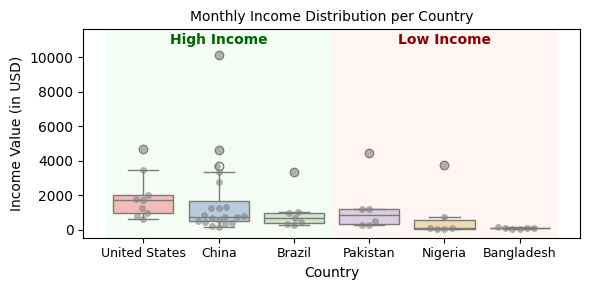

In [80]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Sort Countries by Mean Income
# ---------------------------

# # Apply the function to the 'income' column
filtered_final_result['income_value'] = filtered_final_result['income'].apply(extract_income_value)

# # Get all images per country
# country_income_df = filtered_final_result[['country', 'img_id', 'income_value']].drop_duplicates()
country_income_df = filtered_final_result[filtered_final_result['country'].isin(country_list)][['country', 'income_value']].drop_duplicates()

# Calculate mean income per country and sort them in descending order
country_mean_income = country_income_df.groupby('country')['income_value'].mean().sort_values(ascending=False)

# Extract the sorted list of countries
# sorted_countries = country_mean_income.index.tolist()

# Define high-income and low-income countries
high_income_countries = country_list[:3]  # Top 3
low_income_countries = country_list[-3:]  # Bottom 3

# Update 'country' column as a categorical type with the sorted order
country_income_df['country'] = pd.Categorical(
    country_income_df['country'],
    categories=country_list,
    ordered=True
)

# ---------------------------
# Step 2: Plot Combined Income Distribution and Country-Level Data
# ---------------------------

plt.figure(figsize=(6, 3))  # Increased width for better readability

# Create boxplot
sns.boxplot(
    x='country',
    y='income_value',
    data=country_income_df,
    palette='Pastel1'
)

# Overlay swarmplot
sns.swarmplot(
    x='country',
    y='income_value',
    data=country_income_df,
    color='gray',
    alpha=0.6
)

# ---------------------------
# Step 3: Add Single Annotations for High and Low-Income Countries
# ---------------------------

# Calculate y-position for annotations (slightly above the max income value)
y_max = country_income_df['income_value'].max()
annotation_y = y_max * 1.05  # 5% above the maximum income value

# Calculate center positions for high-income and low-income labels
# Assuming countries are plotted at integer positions starting from 0
num_countries = len(country_list)
high_income_center = (0 + 2) / 2  # Center of first three countries (indices 0,1,2)
low_income_center = (num_countries - 3 + num_countries - 1) / 2  # Center of last three countries

# Add "High Income" label
plt.text(
    x=high_income_center,
    y=annotation_y,
    s='High Income',
    ha='center',
    va='bottom',
    fontsize=10,
    color='darkgreen',
    fontweight='bold'
)

# Add "Low Income" label
plt.text(
    x=low_income_center,
    y=annotation_y,
    s='Low Income',
    ha='center',
    va='bottom',
    fontsize=10,
    color='darkred',
    fontweight='bold'
)

# ---------------------------
# Step 4: Optionally, Draw Shaded Regions for High and Low-Income Countries
# ---------------------------

# Highlight High-Income Countries
plt.axvspan(
    -0.5, 2.5,  # From before the first country to after the third
    facecolor='lightgreen',
    alpha=0.1,
    label='High Income'
)

# Highlight Low-Income Countries
plt.axvspan(
    num_countries - 3 - 0.5, num_countries - 0.5,
    facecolor='lightsalmon',
    alpha=0.1,
    label='Low Income'
)

# ---------------------------
# Step 5: Customize Plot Appearance
# ---------------------------

plt.xlabel('Country')
plt.ylabel('Income Value (in USD)')
plt.title('Monthly Income Distribution per Country', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=9)

# Adjust y-axis limit to accommodate annotations
plt.ylim(top=annotation_y + y_max * 0.10)  # Add extra space above annotations

# Add legend for shaded regions
# plt.legend(loc='upper right', bbox_to_anchor=(1.28, 1))

plt.tight_layout()

# ---------------------------
# Step 6: Save and Show the Plot
# ---------------------------

# Ensure the 'plots' directory exists
# os.makedirs('plots', exist_ok=True)

# Define the plot path
plot_path = os.path.join('plots', 'income_swarm_distribution_per_country.png')

# Save the plot
plt.savefig(plot_path, bbox_inches='tight', dpi=500)
print(f"Saved income distribution per country at: {plot_path}")

# Display the plot
plt.show()

In [77]:
country_list

['United States', 'China', 'Brazil', 'Pakistan', 'Nigeria', 'Bangladesh']

In [78]:
so that notebook breaks here if you run from top

SyntaxError: expected 'else' after 'if' expression (3735556707.py, line 1)

<!-- Func for marginal distribution calculation -->

<!-- Func to compute jsd and 1-jsd for the marginalized distributions -->

In [ ]:
# from scipy.spatial.distance import jensenshannon

# # Function to calculate Jensen-Shannon Divergence (JSD)
# def calculate_jsd(p, q):
#     if len(p) == 0 or len(q) == 0:  # Check for empty distributions
#         return None  # or return a specific value indicating no valid distributions
#     return jensenshannon(p, q)

<!-- Code to compute jsd and similarity (1-jsd) for the joint distribution -->

In [ ]:
# # Step 1 and 2: Calculate marginalized model prediction and ground truth per topic and question
# final_result = calculate_and_merge_marginal_distribution(
#     final_result, ['question_topic', 'question_text'], 'prob_percent_values', 'md_topic_pred'
# )

# final_result = calculate_and_merge_marginal_distribution(
#     final_result, ['question_topic', 'question_text'], 'selection_answers', 'md_topic_gt'
# )

# # Step 3 and 4: Calculate marginalized model prediction and ground truth across all images per question only
# final_result = calculate_and_merge_marginal_distribution(
#     final_result, ['question_text'], 'prob_percent_values', 'md_all_pred'
# )

# final_result = calculate_and_merge_marginal_distribution(
#     final_result, ['question_text'], 'selection_answers', 'md_all_gt'
# )

# # Calculate JSD for each question topic
# final_result['md_jsd_topic'] = final_result.apply(
#     lambda row: calculate_jsd(row['md_topic_pred'], row['md_topic_gt']), axis=1
# )
# final_result['md_sim_topic'] = 1 - final_result['md_jsd_topic']

# # Calculate JSD for overall predictions and ground truth
# final_result['md_jsd_overall'] = final_result.apply(
#     lambda row: calculate_jsd(row['md_all_pred'], row['md_all_gt']), axis=1
# )
# final_result['md_sim_overall'] = 1 - final_result['md_jsd_overall']

### Plot Question Topic level similarity and JSD values for each country
- This is per country
- Note that all images are for people of same demographic group

In [ ]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.transforms import blended_transform_factory



# # Assuming df_category_similarity is a dictionary with dataframes per topic
# # and 'country_list' is defined as a list of country names in desired order

# # Directory to save individual figures
# individual_figures_dir = 'plots/individual_topic_figures'
# if os.path.exists(individual_figures_dir):
#     shutil.rmtree(individual_figures_dir)
#     print(f"Existed! Deleted {individual_figures_dir} directory")
# os.makedirs(individual_figures_dir, exist_ok=True)

# # List of unique question topics
# question_topics = sorted(final_result['question_topic'].unique())

# # Prepare for plotting
# n_cols = 3  # Number of subplots per row
# n_rows = int(np.ceil(len(question_topics) / n_cols))

# fig_width = 6 * n_cols
# fig_height = 4 * n_rows
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
# axs = axs.flatten()  # Flatten the array of axes


# for idx, topic in enumerate(question_topics):
#     df_category = df_category_similarity[topic].copy()
    
#     # Convert 'Image' column to boolean
#     df_category['Image'] = df_category['Image'].map({'False': False, 'True': True})
    
#     # Calculate mean 'question_topic_mean_similarity' per country and Image scenario
#     df_mean = df_category.groupby(['country', 'Image'])['question_topic_mean_similarity'].mean().reset_index()
    
#     # Pivot the data to have Image scenarios as columns
#     df_pivot = df_mean.pivot(index='country', columns='Image', values='question_topic_mean_similarity').reset_index()
    
#     # Rename columns using boolean keys
#     df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})
    
#     # Ensure both 'Text Similarity' and 'Image Similarity' columns exist
#     if 'Text Similarity' not in df_pivot.columns:
#         df_pivot['Text Similarity'] = np.nan
#     if 'Image Similarity' not in df_pivot.columns:
#         df_pivot['Image Similarity'] = np.nan
    
#     # Drop countries that have missing data in either scenario
#     df_pivot = df_pivot.dropna()
    
#     # Sort countries based on 'country_list'
#     df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)

#     # Drop countries that have missing data in either scenario
#     df_pivot = df_pivot.dropna()
    
#     df_pivot = df_pivot.sort_values('country')
    
#     # Data for plotting
#     countries = df_pivot['country']
#     text_similarities = df_pivot['Text Similarity']
#     image_similarities = df_pivot['Image Similarity']
    
#     x = np.arange(len(countries))  # Label locations
#     width = 0.35  # Width of the bars
    
#     ax = axs[idx]
    
#     # Plot bars on the subplot
#     ax.bar(x - width/2, text_similarities, width, label= 'Country Prompt- No Images')
#     ax.bar(x + width/2, image_similarities, width, label='No Country Prompt- Only Images')
    
#     # Compute the mean similarity for the topic using text-level data only
#     text_mean = df_pivot['Text Similarity'].mean()
    
#     # Plot horizontal red dashed line at text_mean
#     ax.axhline(text_mean, color='red', linestyle='--')

#     # Create a blended transformation for the subplot
#     transform = blended_transform_factory(ax.transAxes, ax.transData)
    
#     # Annotate the mean value on the plot
#     ax.text(0.01, text_mean, f'{text_mean:.2f}', color='black', ha='left', va='bottom', transform=ax.get_yaxis_transform())
    
#     # Remove prefix (e.g., 'A.', 'B.', etc.) from topic name
#     topic_title = topic.split('.', 1)[-1].strip()
    
#     # Add labels, title, and custom x-axis tick labels
#     ax.set_ylabel('Mean Similarity')
#     ax.set_title(f'{topic_title}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(countries, rotation=90)
#     ax.tick_params(axis='x', which='major', labelsize=8)
    
#     # Create individual figure for the topic
#     fig_individual, ax_individual = plt.subplots(figsize=(8, 4))
    
#     # Plot bars on the individual figure
#     ax_individual.bar(x - width/2, text_similarities, width, label= 'Country Prompt- No Images')
#     ax_individual.bar(x + width/2, image_similarities, width, label='No Country Prompt- Only Images')
    
#     # Plot horizontal red dashed line at text_mean
#     ax_individual.axhline(text_mean, color='red', linestyle='--')
    
#     # Annotate the mean value on the individual plot
#     ax_individual.text(0.01, text_mean, f'{text_mean:.2f}', color='black', ha='left', va='bottom', transform=ax_individual.get_yaxis_transform())
    
#     # Add labels, title, and custom x-axis tick labels
#     ax_individual.set_ylabel('Mean Similarity')
#     ax_individual.set_title(f'{topic_title}')
#     ax_individual.set_xticks(x)
#     ax_individual.set_xticklabels(countries, rotation=90)
#     ax_individual.tick_params(axis='x', which='major', labelsize=8)
    
#     # Add legend to individual figure, located in the upper right corner outside the plot area
#     ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
#     # Adjust layout to make room for the legend
#     fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend
    
#     # Save individual figure
#     fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
#     plt.close(fig_individual)  # Close the figure to free memory
    
# # Remove empty subplots if any
# for idx in range(len(question_topics), n_rows * n_cols):
#     fig.delaxes(axs[idx])

# # Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right

# # Add a single legend on the right
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.5), frameon=False)
# # Save the final figure with all subplots
# fig.savefig(f'{individual_figures_dir}/final_similarity_plot.png', bbox_inches='tight')

# plt.show()


### Plot Question Topic level similarity and JSD values for each economic strate 
- This is per low income, middle income and high income
- Note that all images are for people of same demographic group

In [ ]:
# import os
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib.transforms import blended_transform_factory

# # # Define income groups
# # rich_countries = ["United States", "Russia", "Romania", "France", "Spain", "Italy", "South Korea"]
# # medium_countries = ["Mexico", "Mongolia", "Brazil", "Colombia", "Iran", "Indonesia", "Philippines", "China"]
# # poor_countries = ["Ethiopia", "Nigeria", "Egypt", "Kenya", "Vietnam", "Bangladesh", "Pakistan"]

# # Create mapping from country to income group
# country_income_group = {}
# for country in ds_rich_countries:
#     country_income_group[country] = 'Rich'
# for country in ds_medium_countries:
#     country_income_group[country] = 'Medium'
# for country in ds_poor_countries:
#     country_income_group[country] = 'Poor'

# # Directory to save individual figures
# individual_figures_dir = 'ds_wvs/individual_topic_figures_income_groups'
# if os.path.exists(individual_figures_dir):
#     shutil.rmtree(individual_figures_dir)
#     print(f"Existed! Deleted {individual_figures_dir} directory")
# os.makedirs(individual_figures_dir, exist_ok=True)

# # List of unique question topics
# question_topics = sorted(final_result['question_topic'].unique())

# # Prepare for plotting
# n_cols = 3  # Number of subplots per row
# n_rows = int(np.ceil(len(question_topics) / n_cols))

# fig_width = 6 * n_cols
# fig_height = 4 * n_rows
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
# axs = axs.flatten()  # Flatten the array of axes

# for idx, topic in enumerate(question_topics):
#     df_category = df_category_similarity[topic].copy()
    
#     # Map 'country' to 'IncomeGroup'
#     df_category['IncomeGroup'] = df_category['country'].map(country_income_group)
    
#     # Remove rows with missing IncomeGroup
#     df_category = df_category.dropna(subset=['IncomeGroup'])
    
#     # Convert 'Image' column to boolean
#     df_category['Image'] = df_category['Image'].map({'False': False, 'True': True})
    
#     # Calculate mean 'question_topic_mean_similarity' per IncomeGroup and Image scenario
#     df_mean = df_category.groupby(['IncomeGroup', 'Image'])['question_topic_mean_similarity'].mean().reset_index()
    
#     # Pivot the data to have Image scenarios as columns
#     df_pivot = df_mean.pivot(index='IncomeGroup', columns='Image', values='question_topic_mean_similarity').reset_index()
    
#     # Rename columns using boolean keys
#     df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})
    
#     # Ensure both 'Text Similarity' and 'Image Similarity' columns exist
#     if 'Text Similarity' not in df_pivot.columns:
#         df_pivot['Text Similarity'] = np.nan
#     if 'Image Similarity' not in df_pivot.columns:
#         df_pivot['Image Similarity'] = np.nan
    
#     # Drop IncomeGroups that have missing data in either scenario
#     df_pivot = df_pivot.dropna()
    
#     # Sort IncomeGroups in the order Rich, Medium, Poor
#     income_group_order = ['Rich', 'Medium', 'Poor']
#     df_pivot['IncomeGroup'] = pd.Categorical(df_pivot['IncomeGroup'], categories=income_group_order, ordered=True)

#     # Drop countries that have missing data in either scenario
#     df_pivot = df_pivot.dropna()
#     df_pivot = df_pivot.sort_values('IncomeGroup')
    
#     # Data for plotting
#     income_groups = df_pivot['IncomeGroup']
#     text_similarities = df_pivot['Text Similarity']
#     image_similarities = df_pivot['Image Similarity']
    
#     x = np.arange(len(income_groups))  # Label locations
#     width = 0.35  # Width of the bars
    
#     ax = axs[idx]
    
#     # Plot bars on the subplot
#     ax.bar(x - width/2, text_similarities, width, label='Country Prompt- No Images')
#     ax.bar(x + width/2, image_similarities, width, label='No Country Prompt- Only Images')
    
#     # Compute the mean similarity for the topic using text-level data only
#     text_mean = df_pivot['Text Similarity'].mean()
    
#     # Plot horizontal red dashed line at text_mean
#     ax.axhline(text_mean, color='red', linestyle='--')
    
#     # Create a blended transformation for the subplot
#     transform = blended_transform_factory(ax.transAxes, ax.transData)
    
#     # Annotate the mean value on the plot (left end)
#     ax.text(0.05, text_mean, f'{text_mean:.2f}', color='black',
#             ha='left', va='bottom', transform=transform)
    
#     # Remove prefix (e.g., 'A.', 'B.', etc.) from topic name
#     topic_title = topic.split('.', 1)[-1].strip()
    
#     # Add labels, title, and custom x-axis tick labels
#     ax.set_ylabel('Mean Similarity')
#     ax.set_title(f'{topic_title}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(income_groups, rotation=0)
#     ax.tick_params(axis='x', which='major', labelsize=8)
    
#     # Create individual figure for the topic
#     fig_individual, ax_individual = plt.subplots(figsize=(6, 4))
    
#     # Plot bars on the individual figure
#     ax_individual.bar(x - width/2, text_similarities, width, label='Country Prompt- No Images')
#     ax_individual.bar(x + width/2, image_similarities, width, label='No Country Prompt- Only Images')
    
#     # Plot horizontal red dashed line at text_mean
#     ax_individual.axhline(text_mean, color='red', linestyle='--')
    
#     # Annotate the mean value on the individual plot (left end)
#     ax_individual.text(0.05, text_mean, f'{text_mean:.2f}', color='black',
#                        ha='left', va='bottom', transform=ax_individual.get_yaxis_transform())
    
#     # Add labels, title, and custom x-axis tick labels
#     ax_individual.set_ylabel('Mean Similarity')
#     ax_individual.set_title(f'{topic_title}')
#     ax_individual.set_xticks(x)
#     ax_individual.set_xticklabels(income_groups, rotation=0)
#     ax_individual.tick_params(axis='x', which='major', labelsize=8)
    
#     # Add legend to individual figure, located in the upper right corner outside the plot area
#     ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    
#     # Adjust layout to make room for the legend
#     fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend
    
#     # Save individual figure
#     fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
#     plt.close(fig_individual)  # Close the figure to free memory

# # Remove empty subplots if any
# for idx in range(len(question_topics), n_rows * n_cols):
#     fig.delaxes(axs[idx])

# # Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right

# # Add a single legend on the right
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right')

# # Save the final figure with all subplots
# fig.savefig(f'{individual_figures_dir}/final_similarity_plot_income_groups.png', bbox_inches='tight')

# plt.show()


### Computer % change in similarity and JSD values for each question topic per income strata

In [ ]:
# # Initialize a list to store the results
# results = []

# for topic in question_topics:
#     df_category = df_category_similarity[topic].copy()
    
#     # Map 'country' to 'IncomeGroup'
#     df_category['IncomeGroup'] = df_category['country'].map(country_income_group)
    
#     # Remove rows with missing IncomeGroup
#     df_category = df_category.dropna(subset=['IncomeGroup'])
    
#     # Convert 'Image' column to boolean if not already
#     if df_category['Image'].dtype == object:
#         df_category['Image'] = df_category['Image'].map({'False': False, 'True': True})
    
#     # For each income group
#     for income_group in ['Rich', 'Medium', 'Poor']:
#         df_group = df_category[df_category['IncomeGroup'] == income_group]
        
#         # Mean 'Text Similarity' (Image == False)
#         text_similarity_mean = df_group[df_group['Image'] == False]['question_topic_mean_similarity'].mean()
        
#         # Mean 'Image Similarity' (Image == True)
#         image_similarity_mean = df_group[df_group['Image'] == True]['question_topic_mean_similarity'].mean()
        
#         # Compute percentage change from 'Text Similarity' to 'Image Similarity'
#         if text_similarity_mean != 0 and not pd.isnull(text_similarity_mean):
#             percentage_change = ((image_similarity_mean - text_similarity_mean) / text_similarity_mean) * 100
#         else:
#             percentage_change = None  # or np.nan
        
#         # Store the result
#         results.append({
#             'Topic': topic,
#             'IncomeGroup': income_group,
#             'Text Similarity IG Mean': text_similarity_mean,
#             'Image Similarity IG Mean': image_similarity_mean,
#             'Percentage Change': percentage_change
#         })

# # Convert results to DataFrame
# df_variance_income_groups = pd.DataFrame(results)

# df_variance_income_groups.head(4)

In [ ]:
# # Pivot the DataFrame to have topics as columns and similarity and percentage change as rows
# df_pivot_topicwise = df_variance_income_groups.pivot(index='IncomeGroup', columns='Topic', values=['Text Similarity IG Mean', 'Image Similarity IG Mean', 'Percentage Change'])

# # Flatten the MultiIndex columns
# df_pivot_topicwise.columns = ['_'.join(col).strip() for col in df_pivot_topicwise.columns.values]

# # Display the updated DataFrame with only % change columns
# df_pivot_topicwise = df_pivot_topicwise.filter(like='Percentage Change', axis=1)
# df_pivot_topicwise = df_pivot_topicwise.reindex(['Rich', 'Medium', 'Poor'])
# df_pivot_topicwise

In [ ]:
# for each unique country, there is a column 'income'. It has tensor values e.g. tensor(174, dtype=torch.float64). I want to plot a historgram of these values for a) per country b) per income group

## Plot distribution of income 

In [ ]:
# import pandas as pd
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# from torch import Tensor
# import re

# # Directory to save individual figures
# individual_figures_income_dist = 'ds_wvs/individual_topic_figures_income_distribution'
# if os.path.exists(individual_figures_income_dist):
#     shutil.rmtree(individual_figures_income_dist)
#     print(f"Existed! Deleted {individual_figures_income_dist} directory")
# os.makedirs(individual_figures_income_dist, exist_ok=True)


In [ ]:
# # Step 1: Extract numerical income values from tensors

# def extract_income_value(tensor_value):
#     if isinstance(tensor_value, str):
#         # Use regex to extract the number inside 'tensor(...)'
#         match = re.search(r'tensor\(([\d\.\-e]+)', tensor_value)
#         if match:
#             return float(match.group(1))
#         else:
#             return np.nan  # or raise an error if appropriate
#     elif isinstance(tensor_value, torch.Tensor):
#         return tensor_value.item()
#     else:
#         return float(tensor_value)

# # Apply the function to the 'income' column
# df_category['income_value'] = df_category['income'].apply(extract_income_value)

# # Since 'income_value' is the same for each country regardless of 'Image', get unique countries and their incomes
# country_income_df = df_category[['country', 'img_id', 'income_value']].drop_duplicates()

# # Verify if 'income_value' is unique per country
# unique_incomes = country_income_df.groupby(['country', 'img_id'])['income_value'].nunique()
# if unique_incomes.max() > 1:
#     print("Warning: Some countries have multiple income values.")

In [ ]:
# # Step 2: Sort countries based on 'income_value' in descending order
# country_income_df_sorted = country_income_df.sort_values('income_value', ascending=False).reset_index(drop=True)


In [ ]:
country_income_df_sorted.head(10)

#### Per Country

In [ ]:
# # Step 3: Create per-country subplots showing income
# import math

# # Get list of unique countries
# unique_countries = country_income_df_sorted['country'].unique()
# num_countries = len(unique_countries)

# # Determine subplot grid size (e.g., 4 columns)
# n_cols = 4
# n_rows = math.ceil(num_countries / n_cols)

# # Create subplots
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
# axs = axs.flatten()

# for idx, country in enumerate(unique_countries):
#     ax = axs[idx]
#     df_country = country_income_df_sorted[country_income_df_sorted['country'] == country]
    
#     # Sort images by income_value ascendingly
#     df_country_sorted = df_country.sort_values('income_value', ascending=True)
    
#     images = df_country_sorted['img_id']
#     incomes = df_country_sorted['income_value']
    
#     ax.bar(images, incomes, color='skyblue', edgecolor='black')
#     ax.set_title(country, fontsize=10)
#     ax.set_ylim(0, incomes.max() * 1.1)
#     ax.set_xlabel('Images', fontsize=8)
#     ax.set_ylabel('Income Value', fontsize=8)
#     ax.tick_params(axis='x', rotation=90, labelsize=0)
#     # dont show x-axis labels
#     ax.set_xticklabels([])
    
#     # Annotate income values
#     # for i, v in enumerate(incomes):
#     #     ax.text(i, v + incomes.max() * 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=6)
    
#     # Add horizontal line for mean income of the country
#     mean_income = incomes.mean()
#     ax.axhline(mean_income, color='red', linestyle='--', linewidth=1)
#     ax.text(len(images)-1, mean_income, f'Mean: {mean_income:.2f}', color='red', ha='right', va='bottom', fontsize=6)

# # Remove any unused subplots
# for j in range(idx + 1, len(axs)):
#     fig.delaxes(axs[j])

# plt.tight_layout()

# # Save the figure
# histogram_plot_path =  os.path.join(individual_figures_income_dist, 'sorted_income_per_country.png')
# plt.savefig(histogram_plot_path, bbox_inches='tight')
# print(f"Saved sorted income histograms per country at: {histogram_plot_path}")

# plt.show()


#### Per Income Group

In [ ]:
# # Step 2: Create sorted bar plots of income values per income group

# import math
# # Add IncomeGroup to country_income_df
# country_income_df['IncomeGroup'] = country_income_df['country'].map(country_income_group)

# # Remove any countries without an income group
# country_income_df = country_income_df.dropna(subset=['IncomeGroup'])

# # Get list of income groups
# income_groups = ['Rich', 'Medium', 'Poor']

# # Create subplots for each income group
# n_cols = 1
# n_rows = len(income_groups)
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(6, 3 * n_rows), sharex=False)
# if n_rows == 1:
#     axs = [axs]

# for idx, group in enumerate(income_groups):
#     ax = axs[idx]
#     df_group = country_income_df[country_income_df['IncomeGroup'] == group]
    
#     # Sort by income_value ascendingly
#     df_group_sorted = df_group.sort_values('income_value', ascending=True)
    
#     images = df_group_sorted['img_id']
#     incomes = df_group_sorted['income_value']
    
#     ax.bar(images, incomes, color='skyblue', edgecolor='black')
#     ax.set_title(f'{group} Countries', fontsize=12)
#     ax.set_ylim(0, incomes.max() * 1.1)
#     ax.set_xlabel('Images', fontsize=10)
#     ax.set_ylabel('Income Value', fontsize=10)
#     ax.tick_params(axis='x', rotation=90, labelsize=8)
#     ax.set_xticklabels([])
    
#     # # Annotate income values
#     # for i, v in enumerate(incomes):
#     #     ax.text(i, v + incomes.max() * 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=7)
    
#     # Add horizontal line for mean income of the group
#     # mean_income = incomes.mean()
#     # ax.axhline(mean_income, color='red', linestyle='--', linewidth=1)
#     # ax.text(len(images)-1, mean_income, f'Mean: {mean_income:.2f}', color='red', ha='right', va='bottom', fontsize=8)

# plt.tight_layout()
# histogram_plot_path = os.path.join(individual_figures_income_dist, 'sorted_income_histograms_per_income_group.png')
# plt.savefig(histogram_plot_path, bbox_inches='tight')
# print(f"Saved sorted income histograms per income group at: {histogram_plot_path}")
# plt.show()


### Show the income distribution in one single plots

In [ ]:

# # Apply the function to the 'income' column
# df_category['income_value'] = df_category['income'].apply(extract_income_value)

# # Get all images per country
# country_income_df = df_category[['country', 'img_id', 'income_value']].drop_duplicates()

# # Verify if 'income_value' is unique per country and img_id
# unique_incomes = country_income_df.groupby(['country', 'img_id'])['income_value'].nunique()
# if unique_incomes.max() > 1:
#     print("Warning: Some countries have multiple income values.")

# # Add IncomeGroup
# country_income_df['IncomeGroup'] = country_income_df['country'].map(country_income_group)

# # Remove any countries without an income group
# country_income_df = country_income_df.dropna(subset=['IncomeGroup'])

# # Sort countries by mean income
# country_mean_income = country_income_df.groupby('country')['income_value'].mean().sort_values(ascending=False).index
# country_income_df['country'] = pd.Categorical(country_income_df['country'], categories=country_mean_income, ordered=True)

# # Plot combined income distribution and country-level data
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='country', y='income_value', data=country_income_df, order=country_mean_income, palette='Pastel1')
# sns.swarmplot(x='country', y='income_value', data=country_income_df, color='gray', alpha=0.6, order=country_mean_income)

# plt.xlabel('Country')
# plt.ylabel('Income Value')
# plt.title('Income Distribution per Country')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plot_path = os.path.join(individual_figures_income_dist, 'income_swarm_distribution_per_country.png')
# plt.savefig(plot_path, bbox_inches='tight')
# print(f"Saved income distribution per country at: {plot_path}")
# plt.show()

# # Save the plot
